In [1]:
import pandas as pd
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,StackingRegressor
from xgboost import XGBRegressor 
import matplotlib.pyplot as plt
import numpy as np
import holidays
import seaborn as sns
sns.set_theme()
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,PolynomialFeatures

In [2]:
data = pd.read_csv('../data/data-for-EDA.csv',sep=',')

In [3]:
data.head()

,Reference Number,Date Created,Date Closed,Request Status,Service Category,Service Code,Business Unit,Neighbourhood,Community League,Ward,...,Count,Geometry Point,Closing Duration,Request Month,Request Day,Source_Apps,Source_Calls,Source_Emails,Source_Research,Source_Web Forms
0,8009029747,2014-01-01,2014-01-02,Closed,Drainage Maintenance,Broken Manhole Cover,Drainage Operations,DOWNTOWN,The Rossdale Community League (1974),O-day'min,...,1,POINT (-113.4974001685949 53.53514971426547),1 days,1,1,0,1,0,0,0
1,8009029007,2014-01-01,2014-01-03,Closed,Litter & Waste,Boulevard,Roadway Operations,DOWNTOWN,Downtown Edmonton Community League,O-day'min,...,1,POINT (-113.4917908674834 53.54507352916345),2 days,1,1,0,1,0,0,0
2,8009026308,2014-01-01,2014-01-01,Closed,Snow & Ice Maintenance,Sanding,Roadway Operations,CLOVER BAR AREA,Prince Charles Community League,Dene,...,1,POINT (-113.3731095136217 53.57092929512665),0 days,1,1,0,1,0,0,0
3,8009028303,2014-01-01,2014-01-01,Closed,Snow & Ice Maintenance,Sanding,Roadway Operations,MAYLIEWAN,Kilkenny Community League,tastawiyiniwak,...,1,POINT (-113.4602798343155 53.61926740481111),0 days,1,1,0,1,0,0,0
4,8009027851,2014-01-01,2014-01-01,Closed,Snow & Ice Maintenance,Sanding,Roadway Operations,INGLEWOOD,Woodcroft Community League,Anirniq,...,1,POINT (-113.5514049837963 53.55890777354586),0 days,1,1,0,1,0,0,0


In [4]:
data = data.drop(columns=['Source_Apps','Source_Calls','Source_Emails','Source_Research','Source_Web Forms'])

In [5]:
data.head(2)

,Reference Number,Date Created,Date Closed,Request Status,Service Category,Service Code,Business Unit,Neighbourhood,Community League,Ward,...,Lat,Long,Location,Ticket Source,Request Year,Count,Geometry Point,Closing Duration,Request Month,Request Day
0,8009029747,2014-01-01,2014-01-02,Closed,Drainage Maintenance,Broken Manhole Cover,Drainage Operations,DOWNTOWN,The Rossdale Community League (1974),O-day'min,...,53.535150,-113.497400,"(53.535149714265465, -113.49740016859494)",Calls,2014,1,POINT (-113.4974001685949 53.53514971426547),1 days,1,1
1,8009029007,2014-01-01,2014-01-03,Closed,Litter & Waste,Boulevard,Roadway Operations,DOWNTOWN,Downtown Edmonton Community League,O-day'min,...,53.545074,-113.491791,"(53.545073529163446, -113.49179086748339)",Calls,2014,1,POINT (-113.4917908674834 53.54507352916345),2 days,1,1


In [6]:
# Convert date columns to datetime
data['Date Created'] = pd.to_datetime(data['Date Created'])
data['Date Closed'] = pd.to_datetime(data['Date Closed'])
data
data.columns

Index(['Reference Number', 'Date Created', 'Date Closed', 'Request Status',
       'Service Category', 'Service Code', 'Business Unit', 'Neighbourhood',
       'Community League', 'Ward', 'Address', 'Lat', 'Long', 'Location',
       'Ticket Source', 'Request Year', 'Count', 'Geometry Point',
       'Closing Duration', 'Request Month', 'Request Day'],
      dtype='object')

In [7]:
# For daily aggregation
daily_requests = data.groupby(['Neighbourhood', 'Date Created']).size().reset_index(name='Request Count')

In [8]:
daily_requests.sample()

,Neighbourhood,Date Created,Request Count
185002,FRASER,2022-08-17,2


In [9]:
# For monthly aggregation
data['YearMonth'] = data['Date Created'].dt.to_period('M')
monthly_requests = data.groupby(['Neighbourhood', 'YearMonth']).size().reset_index(name='Request Count')

In [10]:
monthly_requests.sample()

,Neighbourhood,YearMonth,Request Count
34174,PRINCE RUPERT,2014-02,1


In [11]:
daily_requests['Request year'] = daily_requests['Date Created'].dt.year
monthly_requests['Request year'] = monthly_requests['YearMonth'].dt.year

Getting Weekend, Seasons, Holidays, day of week encoding 

In [12]:
def features(df):
    '''
    Function to create new features for seasons and holidays based on dates
    Args:
        df (pd.DataFrame): DataFrame with a 'Date of Request' column
    Returns:
        pd.DataFrame: DataFrame with additional features
    '''

    # Add Day of Week
    df['day_of_week'] = df['Date Created'].dt.dayofweek
    # data_dummies = pd.get_dummies(df['day_of_week'], prefix='day_of_week')
    # df = pd.concat([df, data_dummies.astype('int')], axis=1)
    
    # Add Month and Seasonal Features
    df['month'] = df['Date Created'].dt.month
    # seasonal_dummies = pd.get_dummies(df['month'], prefix='month')
    # df = pd.concat([df, seasonal_dummies.astype('int')], axis=1)

    # Add Is_Weekend Feature
    df['Is_Weekend'] = (df['day_of_week'] >= 5).astype('int')

    # Add Seasonal Features
    df['season_spring'] = df['month'].isin([3, 4, 5]).astype('int')
    df['season_summer'] = df['month'].isin([6, 7, 8]).astype('int')
    df['season_fall'] = df['month'].isin([9, 10, 11]).astype('int')
    df['season_winter'] = df['month'].isin([12, 1, 2]).astype('int')

    # Create a dictionary of holidays for each year present in the DataFrame
    # years = df['Date Created'].dt.year.unique()
    # holidays_by_year = {year: holidays.Canada(years=[year], prov='AB').keys() for year in years}

    # # Convert the 'Date of Request' to date and check if it's a holiday
    # df['Holiday'] = df['Date Created'].dt.date.apply(
    #     lambda x: 1 if x in holidays_by_year.get(x.year, []) else 0
    # )
    
    # Drop redundant columns if needed
    df.drop(['day_of_week', 'month'], axis=1, inplace=True)

    return df

In [13]:
def monthly_features(df):
    '''
    Function to create new features for seasons and holidays based on monthly dates
    Args:
        df (pd.DataFrame): DataFrame with 'YearMonth' and 'Request Count' columns
    Returns:
        pd.DataFrame: DataFrame with additional features
    '''

    # Convert 'YearMonth' to datetime format (first day of the month)
    df['YearMonth'] = pd.to_datetime(df['YearMonth'].astype(str) + '-01')
    
    # Extract month and year from the datetime
    df['month'] = df['YearMonth'].dt.month
    df['year'] = df['YearMonth'].dt.year
    
    # Add seasonal features based on month
    df['season_spring'] = df['month'].isin([3, 4, 5]).astype('int')
    df['season_summer'] = df['month'].isin([6, 7, 8]).astype('int')
    df['season_fall'] = df['month'].isin([9, 10, 11]).astype('int')
    df['season_winter'] = df['month'].isin([12, 1, 2]).astype('int')

    # # Create a dictionary of holidays for each year present in the DataFrame
    # holidays_by_year = {year: holidays.Canada(years=[year], prov='AB').keys() for year in df['year'].unique()}
    
    # # Convert the 'YearMonth' to the first day of the month and check if it's a holiday
    # df['Holiday'] = df['YearMonth'].dt.date.apply(
    #     lambda x: 1 if x in holidays_by_year.get(x.year, []) else 0
    # )
    
    # Drop redundant columns if needed
    df.drop(['month', 'year'], axis=1, inplace=True)

    return df

In [14]:
daily_requests = features(daily_requests)
monthly_requests = monthly_features(monthly_requests)

In [15]:
# daily_requests['Count_exp'] = np.exp(daily_requests['Request Count'])
# monthly_requests['Count_exp'] = np.log(monthly_requests['Request Count'])

Splitting into training and testing set before calculating features based on our target Variable

In [16]:
daily_requests_training = daily_requests[~daily_requests['Request year'].isin([2023, 2024])]
daily_requests_testing = daily_requests[daily_requests['Request year'].isin([2023, 2024])]

monthly_requests_training = monthly_requests[~monthly_requests['Request year'].isin([2023, 2024])]
monthly_requests_testing = monthly_requests[monthly_requests['Request year'].isin([2023, 2024])]

In [17]:
monthly_requests_testing.sample()

,Neighbourhood,YearMonth,Request Count,Request year,season_spring,season_summer,season_fall,season_winter
41325,STEINHAUER,2024-05-01,11,2024,1,0,0,0


In [18]:
# def add_time_series_features(df):
#     '''
#     Function to create lag and rolling mean features for time series data
#     Args:
#         df (pd.DataFrame): DataFrame with a 'Request Count' column and a DateTime index
#     Returns:
#         pd.DataFrame: DataFrame with additional time series features
#     '''
#     # Ensure 'Request Count' column exists
#     if 'Request Count' not in df.columns:
#         raise ValueError("DataFrame must contain a 'Request Count' column")

#     # Reset index if MultiIndex is used
#     df_reset = df.reset_index()

#     # Create cumulative sum feature
#     df_reset['Cumulative_sum'] = df_reset.groupby('Neighbourhood')['Request Count'].cumsum()

#     # Create lag features
#     df_reset['Lag_1'] = df_reset.groupby('Neighbourhood')['Request Count'].shift(1)
#     df_reset['Lag_2'] = df_reset.groupby('Neighbourhood')['Request Count'].shift(2)
#     df_reset['Lag_3'] = df_reset.groupby('Neighbourhood')['Request Count'].shift(3)
#     df_reset['Lag_4'] = df_reset.groupby('Neighbourhood')['Request Count'].shift(4)
#     df_reset['Lag_5'] = df_reset.groupby('Neighbourhood')['Request Count'].shift(5)
    
#     # Create rolling mean features
#     df_reset['Rolling_mean_7days'] = df_reset.groupby('Neighbourhood')['Request Count'].rolling(window=7).mean()
#     df_reset['Rolling_mean_30days'] = df_reset.groupby('Neighbourhood')['Request Count'].rolling(window=30).mean()
#     df_reset['Rolling_mean_90days'] = df_reset.groupby('Neighbourhood')['Request Count'].rolling(window=90).mean()
#     df_reset['Rolling_mean_120days'] = df_reset.groupby('Neighbourhood')['Request Count'].rolling(window=120).mean()
    
#     # Fill missing values with the median of each column
#     for col in ['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5',
#                 'Rolling_mean_7days', 'Rolling_mean_30days',
#                 'Rolling_mean_90days', 'Rolling_mean_120days', 
#                 'Cumulative_sum']:
#         median_value = df_reset[col].median()
#         df_reset[col].fillna(median_value, inplace=True)

#     # # Restore original MultiIndex
#     # df_final = df_reset.set_index(['Date Created', 'Neighbourhood'])
    
#     return df_reset

def add_time_series_features(df):
    '''
    Function to create lag and rolling mean features for time series data
    Args:
        df (pd.DataFrame): DataFrame with a 'Request Count' column and a DateTime index
    Returns:
        pd.DataFrame: DataFrame with additional time series features
    '''
    # Ensure 'Request Count' column exists
    if 'Request Count' not in df.columns:
        raise ValueError("DataFrame must contain a 'Request Count' column")

    # Reset index if MultiIndex is used
    df_reset = df.reset_index()

    # Create cumulative sum feature
    df_reset['Cumulative_sum'] = df_reset.groupby('Neighbourhood')['Request Count'].cumsum()

    # Create lag features
    for lag in range(1, 6):
        df_reset[f'Lag_{lag}'] = df_reset.groupby('Neighbourhood')['Request Count'].shift(lag)

    # Create rolling mean features
    for window in [7, 30, 90, 120]:
        df_reset[f'Rolling_mean_{window}days'] = df_reset.groupby('Neighbourhood')['Request Count'].transform(lambda x: x.rolling(window=window, min_periods=1).mean())

    # Fill missing values with the median of each column
    columns_to_fill = ['Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5',
                       'Rolling_mean_7days', 'Rolling_mean_30days',
                       'Rolling_mean_90days', 'Rolling_mean_120days',
                       'Cumulative_sum']
    
    for col in columns_to_fill:
        median_value = df_reset[col].median()
        df_reset[col].fillna(median_value, inplace=True)

    # df_final = df_reset.set_index(['Date Created', 'Neighbourhood'])

    return df_reset

In [19]:
daily_requests_training.set_index(['Date Created','Neighbourhood'],inplace=True)
daily_requests_testing.set_index(['Date Created','Neighbourhood'],inplace=True)
monthly_requests_training.set_index(['YearMonth','Neighbourhood'],inplace=True)
monthly_requests_testing.set_index(['YearMonth','Neighbourhood'],inplace=True)

In [20]:
daily_requests_training = add_time_series_features(daily_requests_training)
daily_requests_testing = add_time_series_features(daily_requests_testing)
monthly_requests_training = add_time_series_features(monthly_requests_training)
monthly_requests_testing = add_time_series_features(monthly_requests_testing)

In [21]:
daily_requests_training.set_index(['Date Created','Neighbourhood'],inplace=True)
daily_requests_testing.set_index(['Date Created','Neighbourhood'],inplace=True)
monthly_requests_training.set_index(['YearMonth','Neighbourhood'],inplace=True)
monthly_requests_testing.set_index(['YearMonth','Neighbourhood'],inplace=True)

In [22]:
daily_requests_training.sample()

,,Request Count,Request year,Is_Weekend,season_spring,season_summer,season_fall,season_winter,Cumulative_sum,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Rolling_mean_7days,Rolling_mean_30days,Rolling_mean_90days,Rolling_mean_120days
Date Created,Neighbourhood,,,,,,,,,,,,,,,,,
2021-04-27,CHAPPELLE,5,2021,0,1,0,0,0,3622,2.0,1.0,2.0,5.0,2.0,2.571429,2.066667,2.377778,2.35


In [23]:
daily_requests_testing.sample()

,,Request Count,Request year,Is_Weekend,season_spring,season_summer,season_fall,season_winter,Cumulative_sum,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Rolling_mean_7days,Rolling_mean_30days,Rolling_mean_90days,Rolling_mean_120days
Date Created,Neighbourhood,,,,,,,,,,,,,,,,,
2023-09-28,LAUREL,7,2023,0,0,0,1,0,584,3.0,3.0,1.0,4.0,1.0,2.857143,2.1,2.155556,2.1


In [24]:
monthly_requests_training.sample()

,,Request Count,Request year,season_spring,season_summer,season_fall,season_winter,Cumulative_sum,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Rolling_mean_7days,Rolling_mean_30days,Rolling_mean_90days,Rolling_mean_120days
YearMonth,Neighbourhood,,,,,,,,,,,,,,,,
2017-06-01,SPRUCE AVENUE,38,2017,0,1,0,0,673,25.0,14.0,16.0,6.0,4.0,15.714286,15.466667,16.02381,16.02381


In [25]:
monthly_requests_testing.sample()

,,Request Count,Request year,season_spring,season_summer,season_fall,season_winter,Cumulative_sum,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Rolling_mean_7days,Rolling_mean_30days,Rolling_mean_90days,Rolling_mean_120days
YearMonth,Neighbourhood,,,,,,,,,,,,,,,,
2023-07-01,DOWNTOWN,249,2023,0,1,0,0,1380,226.0,213.0,202.0,159.0,151.0,197.142857,197.142857,197.142857,197.142857


In [26]:
daily_requests_training = daily_requests_training.drop(columns='Request year',axis=1)
daily_requests_testing = daily_requests_testing.drop(columns='Request year',axis=1)
monthly_requests_training = monthly_requests_training.drop(columns='Request year',axis=1)
monthly_requests_testing = monthly_requests_testing.drop(columns='Request year',axis=1)


Daily Prediction 

In [27]:
#Featues, Target and Splitting
X_train_daily = daily_requests_training.drop(columns='Request Count',axis=1)
X_test_daily = daily_requests_testing.drop(columns='Request Count',axis=1)
y_train_daily = daily_requests_training['Request Count']
y_test_daily = daily_requests_testing['Request Count']

# Linear Regression
lr_model_daily = LinearRegression()
lr_model_daily.fit(X_train_daily, y_train_daily)
lr_train_predictions = lr_model_daily.predict(X_train_daily)
lr_test_predictions = lr_model_daily.predict(X_test_daily)
lr_train_mse = mean_squared_error(y_train_daily, lr_train_predictions)
lr_test_mse = mean_squared_error(y_test_daily, lr_test_predictions)
lr_train_r2 = r2_score(y_train_daily, lr_train_predictions)
lr_test_r2 = r2_score(y_test_daily, lr_test_predictions)
print(f'Linear Regression Daily Training MSE: {lr_train_mse}')
print(f'Linear Regression Daily Training R2 Score: {lr_train_r2}')
print(f'Linear Regression Daily Test MSE: {lr_test_mse}')
print(f'Linear Regression Daily Test R2 Score: {lr_test_r2}')

# Random Forest
rf_model_daily = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_daily.fit(X_train_daily, y_train_daily)
rf_train_predictions = rf_model_daily.predict(X_train_daily)
rf_test_predictions = rf_model_daily.predict(X_test_daily)
rf_train_mse = mean_squared_error(y_train_daily, rf_train_predictions)
rf_test_mse = mean_squared_error(y_test_daily, rf_test_predictions)
rf_train_r2 = r2_score(y_train_daily, rf_train_predictions)
rf_test_r2 = r2_score(y_test_daily, rf_test_predictions)
print(f'Random Forest Daily Training MSE: {rf_train_mse}')
print(f'Random Forest Daily Training R2 Score: {rf_train_r2}')
print(f'Random Forest Daily Test MSE: {rf_test_mse}')
print(f'Random Forest Daily Test R2 Score: {rf_test_r2}')

# XGBoost
xgb_model_daily = XGBRegressor(n_estimators=100, random_state=42)
xgb_model_daily.fit(X_train_daily, y_train_daily)
xgb_train_predictions = xgb_model_daily.predict(X_train_daily)
xgb_test_predictions = xgb_model_daily.predict(X_test_daily)
xgb_train_mse = mean_squared_error(y_train_daily, xgb_train_predictions)
xgb_test_mse = mean_squared_error(y_test_daily, xgb_test_predictions)
xgb_train_r2 = r2_score(y_train_daily, xgb_train_predictions)
xgb_test_r2 = r2_score(y_test_daily, xgb_test_predictions)
print(f'XGBoost Daily Training MSE: {xgb_train_mse}')
print(f'XGBoost Daily Training R2 Score: {xgb_train_r2}')
print(f'XGBoost Daily Test MSE: {xgb_test_mse}')
print(f'XGBoost Daily Test R2 Score: {xgb_test_r2}')

# Data for graphs later
daily_true = y_test_daily
daily_lr_pred = lr_test_predictions
daily_rf_pred = rf_test_predictions
daily_xgb_pred = xgb_test_predictions


Linear Regression Daily Training MSE: 0.9528833475263441
Linear Regression Daily Training R2 Score: 0.64195879281046
Linear Regression Daily Test MSE: 0.6292245772040064
Linear Regression Daily Test R2 Score: 0.6500654121899744
Random Forest Daily Training MSE: 0.14396584039101204
Random Forest Daily Training R2 Score: 0.9459055471779776
Random Forest Daily Test MSE: 0.6749696332667604
Random Forest Daily Test R2 Score: 0.6246249289068868
XGBoost Daily Training MSE: 0.7272797113810204
XGBoost Daily Training R2 Score: 0.7267282605171204
XGBoost Daily Test MSE: 0.6113770631885531
XGBoost Daily Test R2 Score: 0.6599910259246826


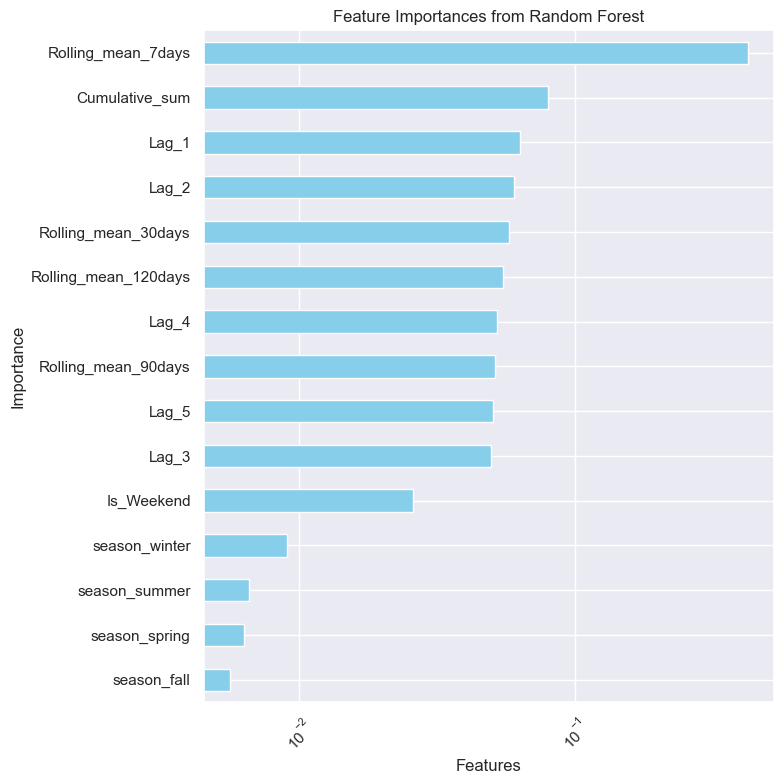

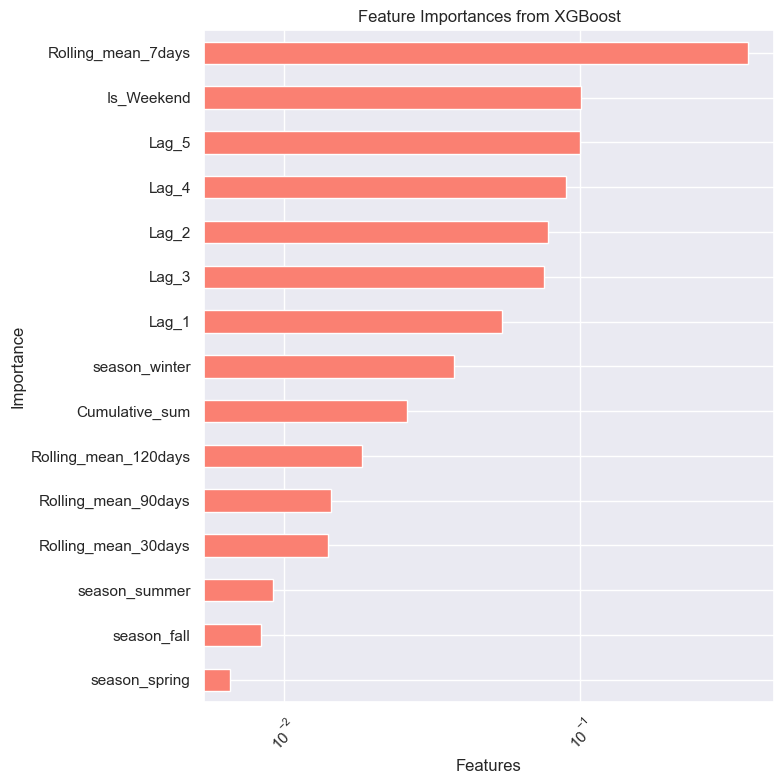

In [28]:
# RandomForest feature importances
rf_importances = rf_model_daily.feature_importances_
# print(type(rf_importances))
# print(rf_importances)
rf_feature_importances = pd.Series(rf_importances, index=X_train_daily.columns).sort_values(ascending=False)

# XGBoost feature importances
xgb_importances = xgb_model_daily.feature_importances_
xgb_feature_importances = pd.Series(xgb_importances, index=X_train_daily.columns).sort_values(ascending=False)

# Plot RandomForest feature importances
plt.figure(figsize=(8, 8))
rf_feature_importances.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xscale('log') 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot XGBoost feature importances
plt.figure(figsize=(8,8))
xgb_feature_importances.sort_values().plot(kind='barh', color='salmon')
plt.title('Feature Importances from XGBoost')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xscale('log') 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Monthly Prediction

In [29]:
#Featues, Target and Splitting
X_train_monthly = monthly_requests_training.drop(columns='Request Count',axis=1)
X_test_monthly = monthly_requests_testing.drop(columns='Request Count',axis=1)
y_train_monthly = monthly_requests_training['Request Count']
y_test_monthly = monthly_requests_testing['Request Count']

In [30]:
X_train_monthly.columns == X_test_monthly.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [31]:


# Linear Regression
lr_model_monthly = LinearRegression()
lr_model_monthly.fit(X_train_monthly, y_train_monthly)
lr_train_predictions = lr_model_monthly.predict(X_train_monthly)
lr_test_predictions = lr_model_monthly.predict(X_test_monthly)
lr_train_mse = mean_squared_error(y_train_monthly, lr_train_predictions)
lr_test_mse = mean_squared_error(y_test_monthly, lr_test_predictions)
lr_train_r2 = r2_score(y_train_monthly, lr_train_predictions)
lr_test_r2 = r2_score(y_test_monthly, lr_test_predictions)
print(f'Linear Regression Monthly Training MSE: {lr_train_mse}')
print(f'Linear Regression Monthly Training R2 Score: {lr_train_r2}')
print(f'Linear Regression Monthly Test MSE: {lr_test_mse}')
print(f'Linear Regression Monthly Test R2 Score: {lr_test_r2}')

# Random Forest
rf_model_monthly = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_monthly.fit(X_train_monthly, y_train_monthly)
rf_train_predictions = rf_model_monthly.predict(X_train_monthly)
rf_test_predictions = rf_model_monthly.predict(X_test_monthly)
rf_train_mse = mean_squared_error(y_train_monthly, rf_train_predictions)
rf_test_mse = mean_squared_error(y_test_monthly, rf_test_predictions)
rf_train_r2 = r2_score(y_train_monthly, rf_train_predictions)
rf_test_r2 = r2_score(y_test_monthly, rf_test_predictions)
print(f'Random Forest Monthly Training MSE: {rf_train_mse}')
print(f'Random Forest Monthly Training R2 Score: {rf_train_r2}')
print(f'Random Forest Monthly Test MSE: {rf_test_mse}')
print(f'Random Forest Monthly Test R2 Score: {rf_test_r2}')

# XGBoost
xgb_model_monthly = XGBRegressor(n_estimators=100, random_state=42)
xgb_model_monthly.fit(X_train_monthly, y_train_monthly)
xgb_train_predictions = xgb_model_monthly.predict(X_train_monthly)
xgb_test_predictions = xgb_model_monthly.predict(X_test_monthly)
xgb_train_mse = mean_squared_error(y_train_monthly, xgb_train_predictions)
xgb_test_mse = mean_squared_error(y_test_monthly, xgb_test_predictions)
xgb_train_r2 = r2_score(y_train_monthly, xgb_train_predictions)
xgb_test_r2 = r2_score(y_test_monthly, xgb_test_predictions)
print(f'XGBoost Monthly Training MSE: {xgb_train_mse}')
print(f'XGBoost Monthly Training R2 Score: {xgb_train_r2}')
print(f'XGBoost Monthly Test MSE: {xgb_test_mse}')
print(f'XGBoost Monthly Test R2 Score: {xgb_test_r2}')

# Data for graphs later
monthly_true = y_test_monthly
monthly_lr_pred = lr_test_predictions
monthly_rf_pred = rf_test_predictions
monthly_xgb_pred = xgb_test_predictions

Linear Regression Monthly Training MSE: 90.35692716761528
Linear Regression Monthly Training R2 Score: 0.8144384580357364
Linear Regression Monthly Test MSE: 82.9712879936647
Linear Regression Monthly Test R2 Score: 0.7902464977880228
Random Forest Monthly Training MSE: 8.560259596946308
Random Forest Monthly Training R2 Score: 0.9824202192325874
Random Forest Monthly Test MSE: 38.30602065248843
Random Forest Monthly Test R2 Score: 0.9031614166544302
XGBoost Monthly Training MSE: 20.949878160944234
XGBoost Monthly Training R2 Score: 0.9569762945175171
XGBoost Monthly Test MSE: 39.86571709338185
XGBoost Monthly Test R2 Score: 0.8992184400558472


##### Daily Metrics Interpretation:

- Linear Regression has the lowest MSE and the highest R2 score among the three models, indicating it performs the best in terms of predicting daily data.
- XGBoost performs slightly worse than Linear Regression but better than Random Forest, as it has a lower MSE and a higher R2 score than Random Forest.
- Random Forest has the highest MSE and the lowest R2 score among the models, suggesting it is less effective for daily data compared to the other models.

##### Monthly Metrics Interpretation:

- Linear Regression again has the lowest MSE and the highest R2 score, making it the best performing model for monthly data as well.
- Random Forest performs better than XGBoost but worse than Linear Regression in this context.
- XGBoost has the highest MSE and the lowest R2 score, indicating it is the least effective for predicting monthly data among the three models.

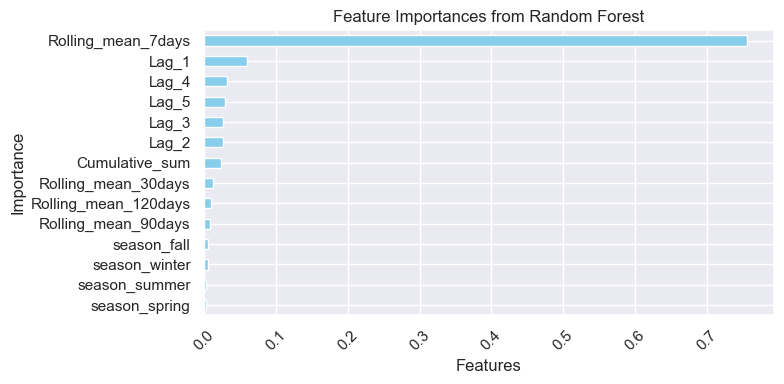

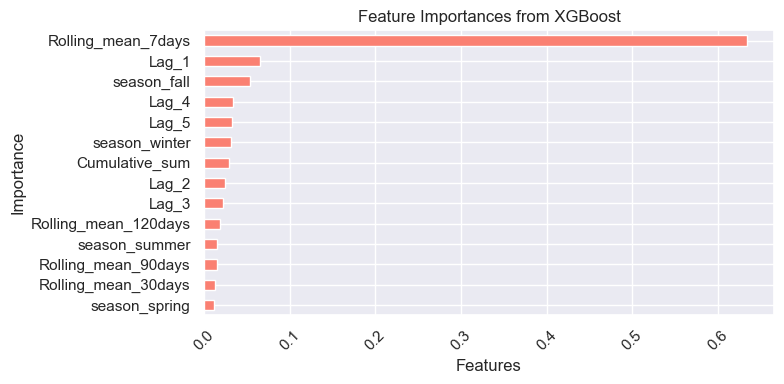

In [32]:
# RandomForest feature importances
rf_importances = rf_model_monthly.feature_importances_
rf_feature_importances = pd.Series(rf_importances, index=X_train_monthly.columns).sort_values(ascending=False)

# XGBoost feature importances
xgb_importances = xgb_model_monthly.feature_importances_
xgb_feature_importances = pd.Series(xgb_importances, index=X_train_monthly.columns).sort_values(ascending=False)

# Plot RandomForest feature importances
plt.figure(figsize=(8, 4))
rf_feature_importances.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
# plt.xscale('log') 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot XGBoost feature importances
plt.figure(figsize=(8,4))
xgb_feature_importances.sort_values().plot(kind='barh', color='salmon')
plt.title('Feature Importances from XGBoost')
plt.xlabel('Features')
plt.ylabel('Importance')
# plt.xscale('log') 
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Comparison via graphs

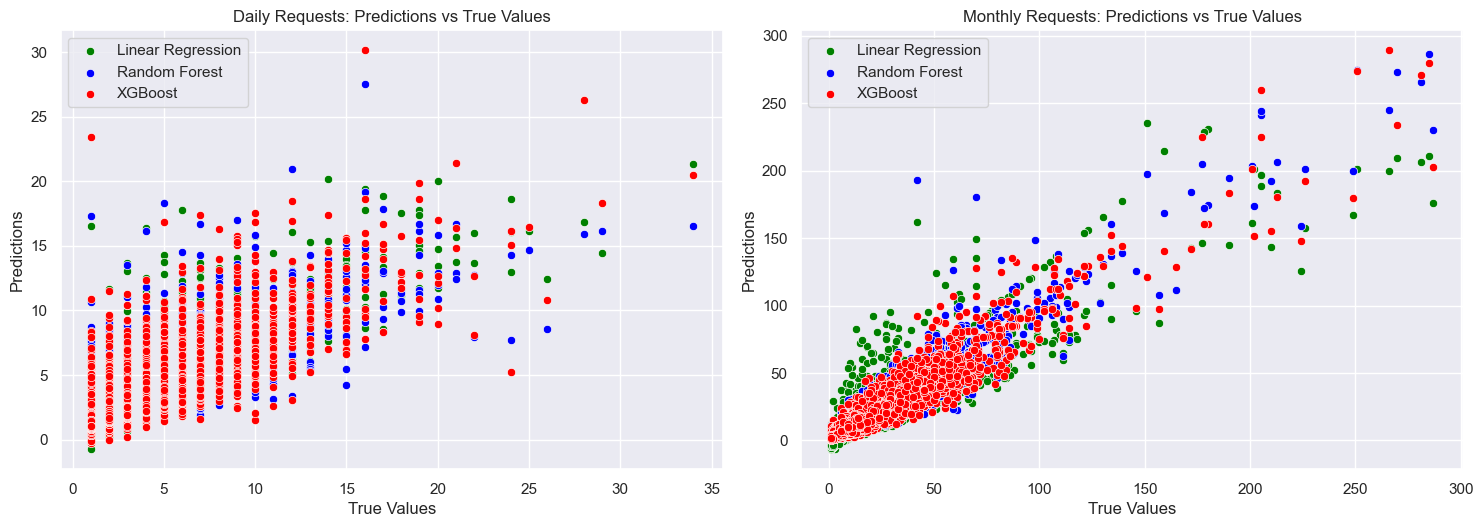

In [33]:
# Create DataFrames for plotting
daily_comparison = pd.DataFrame({
    'True Values': daily_true,
    'LR Predictions': daily_lr_pred,
    'RF Predictions': daily_rf_pred,
    'XGB Predictions': daily_xgb_pred
})

monthly_comparison = pd.DataFrame({
    'True Values': monthly_true,
    'LR Predictions': monthly_lr_pred,
    'RF Predictions': monthly_rf_pred,
    'XGB Predictions': monthly_xgb_pred
})

# Set up the plotting environment
plt.figure(figsize=(15, 10))

# Daily Predictions vs True Values
plt.subplot(2, 2, 1)
sns.scatterplot(x='True Values', y='LR Predictions', data=daily_comparison, color='green', label='Linear Regression')
sns.scatterplot(x='True Values', y='RF Predictions', data=daily_comparison, color='blue', label='Random Forest')
sns.scatterplot(x='True Values', y='XGB Predictions', data=daily_comparison, color='red', label='XGBoost')
plt.title('Daily Requests: Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.grid(True)

# Monthly Predictions vs True Values
plt.subplot(2, 2, 2)
sns.scatterplot(x='True Values', y='LR Predictions', data=monthly_comparison, color='green', label='Linear Regression')
sns.scatterplot(x='True Values', y='RF Predictions', data=monthly_comparison, color='blue', label='Random Forest')
sns.scatterplot(x='True Values', y='XGB Predictions', data=monthly_comparison, color='red', label='XGBoost')
plt.title('Monthly Requests: Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.legend()
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

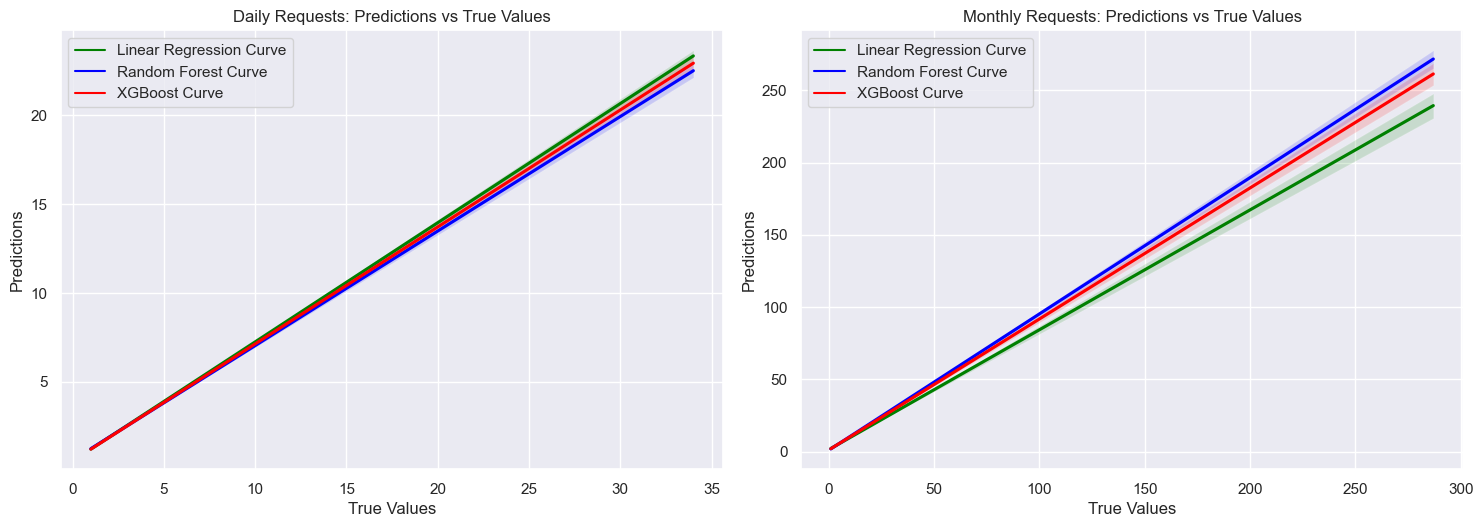

In [34]:
import matplotlib.lines as mlines

# Set up the plotting environment
plt.figure(figsize=(15, 10))

# Daily Predictions vs True Values with Smooth Curves
plt.subplot(2, 2, 1)
# Plot smooth curves
sns.regplot(x='True Values', y='LR Predictions', data=daily_comparison, scatter=False, color='green')
sns.regplot(x='True Values', y='RF Predictions', data=daily_comparison, scatter=False, color='blue')
sns.regplot(x='True Values', y='XGB Predictions', data=daily_comparison, scatter=False, color='red')

# Add custom legend
lr_line = mlines.Line2D([], [], color='green', label='Linear Regression Curve')
rf_line = mlines.Line2D([], [], color='blue', label='Random Forest Curve')
xgb_line = mlines.Line2D([], [], color='red', label='XGBoost Curve')
plt.legend(handles=[lr_line, rf_line, xgb_line])

plt.title('Daily Requests: Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)

# Monthly Predictions vs True Values with Smooth Curves
plt.subplot(2, 2, 2)
# Plot smooth curves
sns.regplot(x='True Values', y='LR Predictions', data=monthly_comparison, scatter=False, color='green')
sns.regplot(x='True Values', y='RF Predictions', data=monthly_comparison, scatter=False, color='blue')
sns.regplot(x='True Values', y='XGB Predictions', data=monthly_comparison, scatter=False, color='red')

# Add custom legend
plt.legend(handles=[lr_line, rf_line, xgb_line])

plt.title('Monthly Requests: Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()

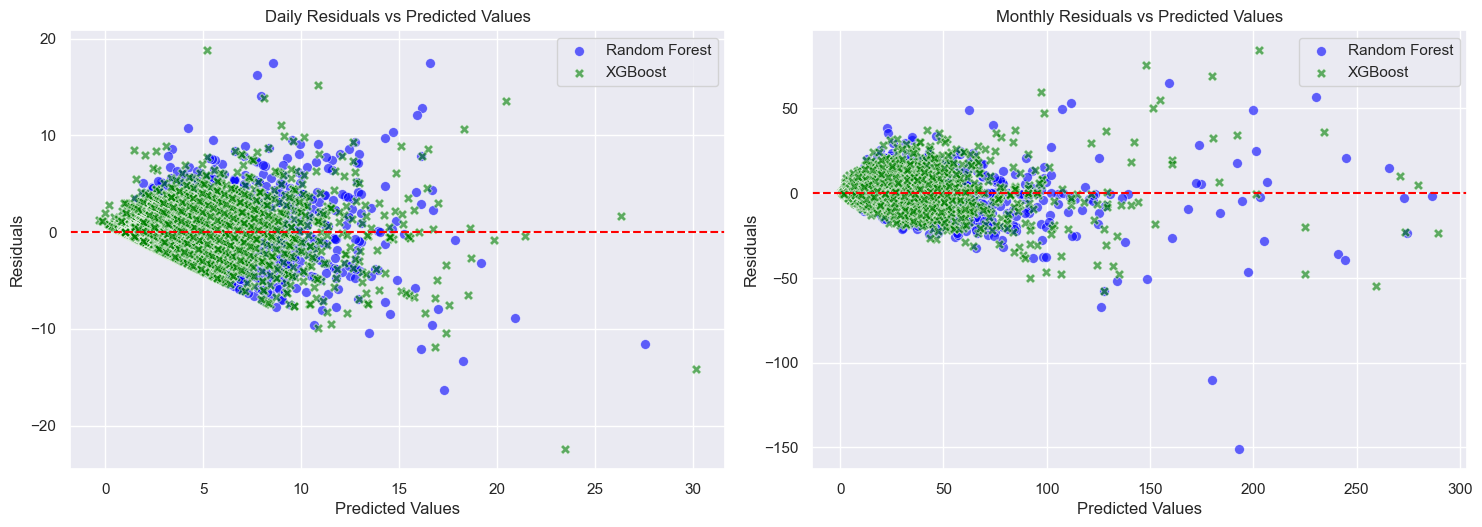

In [42]:
# Calculate residuals
daily_comparison = pd.DataFrame({
    'True Values': daily_true,
    'RF Predictions': daily_rf_pred,
    'XGB Predictions': daily_xgb_pred
})
daily_comparison['RF Residuals'] = daily_comparison['True Values'] - daily_comparison['RF Predictions']
daily_comparison['XGB Residuals'] = daily_comparison['True Values'] - daily_comparison['XGB Predictions']

monthly_comparison = pd.DataFrame({
    'True Values': monthly_true,
    'RF Predictions': monthly_rf_pred,
    'XGB Predictions': monthly_xgb_pred
})
monthly_comparison['RF Residuals'] = monthly_comparison['True Values'] - monthly_comparison['RF Predictions']
monthly_comparison['XGB Residuals'] = monthly_comparison['True Values'] - monthly_comparison['XGB Predictions']

# Set up the plotting environment
plt.figure(figsize=(15, 10))

# Daily residuals
plt.subplot(2, 2, 1)
sns.scatterplot(x=daily_comparison['RF Predictions'], y=daily_comparison['RF Residuals'],
                color='blue', label='Random Forest', marker='o', s=50, alpha=0.6)
sns.scatterplot(x=daily_comparison['XGB Predictions'], y=daily_comparison['XGB Residuals'],
                color='green', label='XGBoost', marker='X', s=50, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')  # Horizontal line at zero
plt.title('Daily Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)

# Monthly residuals
plt.subplot(2, 2, 2)
sns.scatterplot(x=monthly_comparison['RF Predictions'], y=monthly_comparison['RF Residuals'],
                color='blue', label='Random Forest', marker='o', s=50, alpha=0.6)
sns.scatterplot(x=monthly_comparison['XGB Predictions'], y=monthly_comparison['XGB Residuals'],
                color='green', label='XGBoost', marker='X', s=50, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')  # Horizontal line at zero
plt.title('Monthly Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Calculate absolute errors
daily_lr_error = abs(daily_lr_pred - daily_true)
daily_rf_error = abs(daily_rf_pred - daily_true)
daily_xgb_error = abs(daily_xgb_pred - daily_true)

monthly_lr_error = abs(monthly_lr_pred - monthly_true)
monthly_rf_error = abs(monthly_rf_pred - monthly_true)
monthly_xgb_error = abs(monthly_xgb_pred - monthly_true)

# Plot prediction errors
plt.figure(figsize=(15, 10))

# Daily prediction errors
plt.subplot(2, 2, 1)
sns.histplot(daily_lr_error, color='green', label='Linear Regression', kde=True)
sns.histplot(daily_rf_error, color='blue', label='Random Forest', kde=True)
sns.histplot(daily_xgb_error, color='red', label='XGBoost', kde=True)
plt.title('Daily Prediction Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Monthly prediction errors
plt.subplot(2, 2, 2)
sns.histplot(monthly_lr_error, color='green', label='Linear Regression', kde=True)
sns.histplot(monthly_rf_error, color='blue', label='Random Forest', kde=True)
sns.histplot(monthly_xgb_error, color='red', label='XGBoost', kde=True)
plt.title('Monthly Prediction Errors')
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [34]:
daily_requests_sample = daily_requests_testing.sample(n=25, random_state=42)
monthly_requests_sample = monthly_requests_testing.sample(n=25, random_state=42)

In [35]:
# Make predictions for daily sample
daily_lr_predictions = lr_model_daily.predict(daily_requests_sample.drop(columns='Request Count',axis=1))
daily_rf_predictions = rf_model_daily.predict(daily_requests_sample.drop(columns='Request Count',axis=1))
daily_xgb_predictions = xgb_model_daily.predict(daily_requests_sample.drop(columns='Request Count',axis=1))

# Make predictions for monthly sample
monthly_lr_predictions = rf_model_monthly.predict(monthly_requests_sample.drop(columns='Request Count',axis=1))
monthly_rf_predictions = rf_model_monthly.predict(monthly_requests_sample.drop(columns='Request Count',axis=1))
monthly_xgb_predictions = xgb_model_monthly.predict(monthly_requests_sample.drop(columns='Request Count',axis=1))

# Add predictions to sample data
daily_requests_sample['LR Predictions'] = daily_lr_predictions.astype('int')
daily_requests_sample['RF Predictions'] = daily_rf_predictions.astype('int')
daily_requests_sample['XGB Predictions'] = daily_xgb_predictions.astype('int')

monthly_requests_sample['LR Predictions'] = monthly_lr_predictions.astype('int')
monthly_requests_sample['RF Predictions'] = monthly_rf_predictions.astype('int')
monthly_requests_sample['XGB Predictions'] = monthly_xgb_predictions.astype('int')

In [36]:
daily_requests_sample.sample(5)

,,Request Count,Is_Weekend,season_spring,season_summer,season_fall,season_winter,Cumulative_sum,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Rolling_mean_7days,Rolling_mean_30days,Rolling_mean_90days,Rolling_mean_120days,LR Predictions,RF Predictions,XGB Predictions
Date Created,Neighbourhood,,,,,,,,,,,,,,,,,,,
2023-07-20,CALLINGWOOD NORTH,5,0,0,1,0,0,185,1.0,1.0,2.0,1.0,1.0,1.714286,2.033333,1.888889,1.831683,2,3,2
2024-01-18,MATT BERRY,2,0,0,0,0,1,175,2.0,2.0,1.0,2.0,1.0,1.571429,1.433333,1.211111,1.383333,1,1,1
2024-05-27,MONTROSE,1,0,1,0,0,0,340,1.0,1.0,1.0,2.0,1.0,1.142857,1.400000,1.322222,1.375000,1,1,1
2024-06-28,MORIN INDUSTRIAL,1,0,0,1,0,0,78,1.0,2.0,1.0,1.0,1.0,1.142857,1.166667,1.114286,1.114286,1,1,1
2023-10-07,CANORA,2,1,0,0,1,0,320,1.0,2.0,1.0,2.0,2.0,1.857143,1.666667,1.733333,1.741667,2,2,2


In [37]:
monthly_requests_sample.sample(5)

,,Request Count,season_spring,season_summer,season_fall,season_winter,Cumulative_sum,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Rolling_mean_7days,Rolling_mean_30days,Rolling_mean_90days,Rolling_mean_120days,LR Predictions,RF Predictions,XGB Predictions
YearMonth,Neighbourhood,,,,,,,,,,,,,,,,,,
2024-03-01,YELLOWHEAD CORRIDOR EAST,6,1,0,0,0,76,4.0,7.0,5.0,1.0,8.0,5.428571,5.066667,5.066667,5.066667,5,5,7
2023-08-01,STARLING,25,0,1,0,0,103,14.0,10.0,11.0,8.0,13.0,13.000000,12.875000,12.875000,12.875000,12,12,14
2023-11-01,CALGARY TRAIL SOUTH,9,0,0,1,0,86,6.0,7.0,7.0,6.0,13.0,8.285714,7.818182,7.818182,7.818182,6,6,7
2024-01-01,LEGER,20,0,0,0,1,150,12.0,10.0,9.0,10.0,14.0,11.571429,11.538462,11.538462,11.538462,13,13,12
2023-04-01,WHITE INDUSTRIAL,2,1,0,0,0,4,1.0,1.0,11.0,11.0,11.0,1.333333,1.333333,1.333333,1.333333,1,1,1


In [38]:
daily_requests_sample[['Request Count','LR Predictions','RF Predictions','XGB Predictions']]

,,Request Count,LR Predictions,RF Predictions,XGB Predictions
Date Created,Neighbourhood,,,,
2024-03-11,SILVER BERRY,7,5,5,6
2023-08-28,GRIESBACH,1,0,1,1
2023-07-20,CALLINGWOOD NORTH,5,2,3,2
2023-06-19,CLOVERDALE,1,1,1,1
2023-12-13,WINTERBURN INDUSTRIAL AREA EAST,1,1,1,1
2023-04-14,WESTMOUNT,2,1,1,1
2023-12-18,GLENGARRY,2,1,1,1
2024-04-02,WESTWOOD,1,1,1,1
2023-10-07,CANORA,2,2,2,2


In [39]:
monthly_requests_sample[['Request Count','LR Predictions','RF Predictions','XGB Predictions']]

,,Request Count,LR Predictions,RF Predictions,XGB Predictions
YearMonth,Neighbourhood,,,,
2024-03-01,LAURIER HEIGHTS,13,16,16,17
2023-07-01,RUTHERFORD,47,49,49,47
2023-06-01,CUMBERLAND,27,24,24,23
2023-10-01,IDYLWYLDE,18,12,12,11
2024-04-01,MONTROSE,18,28,28,26
2023-01-01,BLACKMUD CREEK RAVINE,5,5,5,4
2023-04-01,WHITE INDUSTRIAL,2,1,1,1
2024-06-01,EDMONTON RESEARCH AND DEVELOPMENT PARK,12,7,7,7
2024-03-01,CROMDALE,27,20,20,24


Hyper Tuning Linear Regression for Daily and Monthly Forecasting
- Daily 
    - MSE: 0.5959
    - R2 Score: 0.6686
- Monthly : 
    - MSE: 62.1381
    - R2 Score: 0.8429

1. Scaling the Features 

In [40]:
# Feature Scaling
scaler = StandardScaler()

X_train_daily = scaler.fit_transform(X_train_daily)
X_test_daily = scaler.transform(X_test_daily)
X_train_monthly = scaler.fit_transform(X_train_monthly)
X_test_monthly = scaler.transform(X_test_monthly)

# Linear Regression
lr_model_daily = LinearRegression()
lr_model_daily.fit(X_train_daily, y_train_daily)
lr_predictions = lr_model_daily.predict(X_test_daily)
lr_mse = mean_squared_error(y_test_daily, lr_predictions)
lr_r2 = r2_score(y_test_daily, lr_predictions)
print(f'Linear Regression Daily MSE: {lr_mse}')
print(f'Linear Regression R2 Score: {lr_r2}')


# Linear Regression
lr_model_montly = LinearRegression()
lr_model_montly.fit(X_train_monthly, y_train_monthly)
lr_predictions = lr_model_montly.predict(X_test_monthly)
lr_mse = mean_squared_error(y_test_monthly, lr_predictions)
lr_r2 = r2_score(y_test_monthly, lr_predictions)
print(f'Linear Regression Monthly MSE: {lr_mse}')
print(f'Linear Regression Monthly R2 Score: {lr_r2}')


Linear Regression Daily MSE: 0.6292221025547232
Linear Regression R2 Score: 0.6500667884321114
Linear Regression Monthly MSE: 82.97819378437778
Linear Regression Monthly R2 Score: 0.7902290397754665


No effect of Scaling.

2. Select K best features

In [41]:
# from sklearn.feature_selection import SelectKBest, f_regression
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import mean_squared_error, r2_score

# # Define the features and targets for daily and monthly data
# X_train_daily = daily_requests_training.drop(columns='Request Count', axis=1)
# X_test_daily = daily_requests_testing.drop(columns='Request Count', axis=1)
# y_train_daily = daily_requests_training['Request Count']
# y_test_daily = daily_requests_testing['Request Count']

# X_train_monthly = monthly_requests_training.drop(columns='Request Count', axis=1)
# X_test_monthly = monthly_requests_testing.drop(columns='Request Count', axis=1)
# y_train_monthly = monthly_requests_training['Request Count']
# y_test_monthly = monthly_requests_testing['Request Count']

# # Define the parameter grid for k
# param_grid = {
#     'selectkbest__k': [1, 5, 10, 15, 20, 'all']  # Adjust based on your data
# }

# # Create a pipeline with feature selection and linear regression
# pipeline_daily = Pipeline([
#     ('scaler', StandardScaler()),
#     ('selectkbest', SelectKBest(score_func=f_regression)),
#     ('regressor', LinearRegression())
# ])

# pipeline_monthly = Pipeline([
#     ('scaler', StandardScaler()),
#     ('selectkbest', SelectKBest(score_func=f_regression)),
#     ('regressor', LinearRegression())
# ])

# # Setup GridSearchCV for daily data
# grid_search_daily = GridSearchCV(pipeline_daily, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search_daily.fit(X_train_daily, y_train_daily)

# # Get the best parameters and model
# best_k_daily = grid_search_daily.best_params_['selectkbest__k']
# best_model_daily = grid_search_daily.best_estimator_

# # Evaluate the best model on the test set
# y_pred_daily = best_model_daily.predict(X_test_daily)
# mse_daily = mean_squared_error(y_test_daily, y_pred_daily)
# r2_daily = r2_score(y_test_daily, y_pred_daily)
# print(f'Best k for Daily Data: {best_k_daily}')
# print(f'Linear Regression Daily MSE: {mse_daily}')
# print(f'Linear Regression Daily R2 Score: {r2_daily}')

# # Setup GridSearchCV for monthly data
# grid_search_monthly = GridSearchCV(pipeline_monthly, param_grid, cv=5, scoring='neg_mean_squared_error')
# grid_search_monthly.fit(X_train_monthly, y_train_monthly)

# # Get the best parameters and model
# best_k_monthly = grid_search_monthly.best_params_['selectkbest__k']
# best_model_monthly = grid_search_monthly.best_estimator_

# # Evaluate the best model on the test set
# y_pred_monthly = best_model_monthly.predict(X_test_monthly)
# mse_monthly = mean_squared_error(y_test_monthly, y_pred_monthly)
# r2_monthly = r2_score(y_test_monthly, y_pred_monthly)
# print(f'Best k for Monthly Data: {best_k_monthly}')
# print(f'Linear Regression Monthly MSE: {mse_monthly}')
# print(f'Linear Regression Monthly R2 Score: {r2_monthly}')

3. Lasso and Ridge Regression

In [42]:
# from sklearn.linear_model import Ridge, Lasso
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, r2_score

# # Define parameter grids for Ridge and Lasso
# param_grid_ridge = {
#     'ridge__alpha': [0.1, 1, 10, 100]  # Regularization strength for Ridge
# }

# param_grid_lasso = {
#     'lasso__alpha': [0.1, 1, 10, 100]  # Regularization strength for Lasso
# }

# # Create pipelines for Ridge and Lasso regression
# pipeline_ridge = Pipeline([
#     ('scaler', StandardScaler()),
#     ('ridge', Ridge())
# ])

# pipeline_lasso = Pipeline([
#     ('scaler', StandardScaler()),
#     ('lasso', Lasso())
# ])

# # Setup GridSearchCV for Ridge regression
# grid_search_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
# grid_search_ridge.fit(X_train_daily, y_train_daily)

# # Get the best parameters and model for Ridge
# best_alpha_ridge = grid_search_ridge.best_params_['ridge__alpha']
# best_model_ridge = grid_search_ridge.best_estimator_

# # Evaluate the Ridge model on the test set
# y_pred_ridge = best_model_ridge.predict(X_test_daily)
# mse_ridge = mean_squared_error(y_test_daily, y_pred_ridge)
# r2_ridge = r2_score(y_test_daily, y_pred_ridge)
# print(f'Best alpha for Ridge Regression: {best_alpha_ridge}')
# print(f'Ridge Regression Daily MSE: {mse_ridge}')
# print(f'Ridge Regression Daily R2 Score: {r2_ridge}')

# # Setup GridSearchCV for Lasso regression
# grid_search_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
# grid_search_lasso.fit(X_train_daily, y_train_daily)

# # Get the best parameters and model for Lasso
# best_alpha_lasso = grid_search_lasso.best_params_['lasso__alpha']
# best_model_lasso = grid_search_lasso.best_estimator_

# # Evaluate the Lasso model on the test set
# y_pred_lasso = best_model_lasso.predict(X_test_daily)
# mse_lasso = mean_squared_error(y_test_daily, y_pred_lasso)
# r2_lasso = r2_score(y_test_daily, y_pred_lasso)
# print(f'Best alpha for Lasso Regression: {best_alpha_lasso}')
# print(f'Lasso Regression Daily MSE: {mse_lasso}')
# print(f'Lasso Regression Daily R2 Score: {r2_lasso}')


In [43]:
# from sklearn.linear_model import Ridge, Lasso
# from sklearn.model_selection import GridSearchCV
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, r2_score

# # Prepare features and targets for monthly data
# X_train_monthly = monthly_requests_training.drop(columns='Request Count', axis=1)
# X_test_monthly = monthly_requests_testing.drop(columns='Request Count', axis=1)
# y_train_monthly = monthly_requests_training['Request Count']
# y_test_monthly = monthly_requests_testing['Request Count']

# # Define parameter grids for Ridge and Lasso
# param_grid_ridge = {
#     'ridge__alpha': [0.1, 1, 10, 100]  # Regularization strength for Ridge
# }

# param_grid_lasso = {
#     'lasso__alpha': [0.1, 1, 10, 100]  # Regularization strength for Lasso
# }

# # Create pipelines for Ridge and Lasso regression
# pipeline_ridge = Pipeline([
#     ('scaler', StandardScaler()),
#     ('ridge', Ridge())
# ])

# pipeline_lasso = Pipeline([
#     ('scaler', StandardScaler()),
#     ('lasso', Lasso())
# ])

# # Setup GridSearchCV for Ridge regression
# grid_search_ridge = GridSearchCV(pipeline_ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error')
# grid_search_ridge.fit(X_train_monthly, y_train_monthly)

# # Get the best parameters and model for Ridge
# best_alpha_ridge = grid_search_ridge.best_params_['ridge__alpha']
# best_model_ridge = grid_search_ridge.best_estimator_

# # Evaluate the Ridge model on the test set
# y_pred_ridge = best_model_ridge.predict(X_test_monthly)
# mse_ridge = mean_squared_error(y_test_monthly, y_pred_ridge)
# r2_ridge = r2_score(y_test_monthly, y_pred_ridge)
# print(f'Best alpha for Ridge Regression (Monthly Data): {best_alpha_ridge}')
# print(f'Ridge Regression Monthly MSE: {mse_ridge}')
# print(f'Ridge Regression Monthly R2 Score: {r2_ridge}')

# # Setup GridSearchCV for Lasso regression
# grid_search_lasso = GridSearchCV(pipeline_lasso, param_grid_lasso, cv=5, scoring='neg_mean_squared_error')
# grid_search_lasso.fit(X_train_monthly, y_train_monthly)

# # Get the best parameters and model for Lasso
# best_alpha_lasso = grid_search_lasso.best_params_['lasso__alpha']
# best_model_lasso = grid_search_lasso.best_estimator_

# # Evaluate the Lasso model on the test set
# y_pred_lasso = best_model_lasso.predict(X_test_monthly)
# mse_lasso = mean_squared_error(y_test_monthly, y_pred_lasso)
# r2_lasso = r2_score(y_test_monthly, y_pred_lasso)
# print(f'Best alpha for Lasso Regression (Monthly Data): {best_alpha_lasso}')
# print(f'Lasso Regression Monthly MSE: {mse_lasso}')
# print(f'Lasso Regression Monthly R2 Score: {r2_lasso}')


In [44]:
# from sklearn.svm import SVR
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import mean_squared_error, r2_score
# import pandas as pd

# # Example Data Preparation
# # Ensure you have the monthly_requests_training and monthly_requests_testing DataFrames prepared
# X_train_monthly = monthly_requests_training.drop(columns='Request Count', axis=1)
# X_test_monthly = monthly_requests_testing.drop(columns='Request Count', axis=1)
# y_train_monthly = monthly_requests_training['Request Count']
# y_test_monthly = monthly_requests_testing['Request Count']

# # Feature Scaling
# scaler = StandardScaler()
# X_train_monthly_scaled = scaler.fit_transform(X_train_monthly)
# X_test_monthly_scaled = scaler.transform(X_test_monthly)

# # Define parameter grid for GridSearchCV
# param_grid = {
#     'C': [0.1, 1, 10, 100],          # Regularization parameter
#     'epsilon': [0.01, 0.1, 0.2],      # Epsilon in the loss function
#     'kernel': ['linear', 'poly', 'rbf', 'sigmoid']  # Kernel types
# }

# # Create SVR model
# svr = SVR()

# # Set up GridSearchCV
# grid_search = GridSearchCV(svr, param_grid, cv=5, scoring='neg_mean_squared_error')

# # Fit GridSearchCV
# grid_search.fit(X_train_monthly_scaled, y_train_monthly)

# # Get the best parameters and model
# best_params = grid_search.best_params_
# best_model = grid_search.best_estimator_

# print(f'Best Parameters for SVR: {best_params}')

# # Make predictions with the best model
# y_pred_best = best_model.predict(X_test_monthly_scaled)

# # Evaluate the best model
# best_mse = mean_squared_error(y_test_monthly, y_pred_best)
# best_r2 = r2_score(y_test_monthly, y_pred_best)

# print(f'Best SVR Monthly MSE: {best_mse}')
# print(f'Best SVR Monthly R2 Score: {best_r2}')


In [45]:
# # Prepare features and targets for Daily Data
# X_train_daily = daily_requests_training.drop(columns='Request Count', axis=1)
# X_test_daily = daily_requests_testing.drop(columns='Request Count', axis=1)
# y_train_daily = daily_requests_training['Request Count']
# y_test_daily = daily_requests_testing['Request Count']

# # Feature Scaling for Daily Data
# scaler = StandardScaler()
# X_train_daily_scaled = scaler.fit_transform(X_train_daily)
# X_test_daily_scaled = scaler.transform(X_test_daily)

# # Random Forest Hyperparameter Tuning for Daily Data
# rf_params = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }
# rf_grid_daily = GridSearchCV(RandomForestRegressor(), rf_params, cv=5, scoring='neg_mean_squared_error',n_jobs=-1)
# rf_grid_daily.fit(X_train_daily_scaled, y_train_daily)
# print(f'Best parameters for Random Forest Daily Data: {rf_grid_daily.best_params_}')


In [46]:

# # XGBoost Hyperparameter Tuning for Daily Data
# xgb_params = {
#     'n_estimators': [50, 100, 200],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [3, 6, 10],
#     'subsample': [0.8, 1.0]
# }
# xgb_grid_daily = GridSearchCV(XGBRegressor(), xgb_params, cv=5, scoring='neg_mean_squared_error',n_jobs=-1)
# xgb_grid_daily.fit(X_train_daily_scaled, y_train_daily)
# print(f'Best parameters for XGBoost Daily Data: {xgb_grid_daily.best_params_}')

In [47]:
# # Evaluate Best Random Forest Model for Daily Data
# best_rf_daily = rf_grid_daily.best_estimator_
# rf_predictions_daily_training = best_rf_daily.predict(X_train_daily_scaled)
# rf_predictions_daily_testing = best_rf_daily.predict(X_test_daily_scaled)
# rf_mse_daily_training = mean_squared_error(y_train_daily, rf_predictions_daily_training)
# rf_mse_daily_testing = mean_squared_error(y_test_daily, rf_predictions_daily_testing)
# rf_r2_daily_training = r2_score(y_train_daily, rf_predictions_daily_training)
# rf_r2_daily_testing = r2_score(y_test_daily, rf_predictions_daily_testing)
# print(f'Random Forest Daily MSE for training: {rf_mse_daily_training}')
# print(f'Random Forest Daily MSE for testing: {rf_mse_daily_testing}')
# print(f'Random Forest Daily R2 Score for training: {rf_r2_daily_training}')
# print(f'Random Forest Daily R2 Score for testing: {rf_r2_daily_testing}')

In [48]:
# # Evaluate Best XGBoost Model for Daily Data
# best_xgb_daily = xgb_grid_daily.best_estimator_

# # Predict on training data
# xgb_predictions_daily_training = best_xgb_daily.predict(X_train_daily_scaled)
# # Predict on testing data
# xgb_predictions_daily_testing = best_xgb_daily.predict(X_test_daily_scaled)

# # Calculate metrics for training data
# xgb_mse_daily_training = mean_squared_error(y_train_daily, xgb_predictions_daily_training)
# xgb_r2_daily_training = r2_score(y_train_daily, xgb_predictions_daily_training)

# # Calculate metrics for testing data
# xgb_mse_daily_testing = mean_squared_error(y_test_daily, xgb_predictions_daily_testing)
# xgb_r2_daily_testing = r2_score(y_test_daily, xgb_predictions_daily_testing)

# # Print metrics
# print(f'XGBoost Daily Training MSE: {xgb_mse_daily_training}')
# print(f'XGBoost Daily Testing MSE: {xgb_mse_daily_testing}')
# print(f'XGBoost Daily Training R2 Score: {xgb_r2_daily_training}')
# print(f'XGBoost Daily Testing R2 Score: {xgb_r2_daily_testing}')

In [49]:
# # Prepare features and targets for Monthly Data (if you have separate monthly data)
# X_train_monthly = monthly_requests_training.drop(columns='Request Count', axis=1)
# X_test_monthly = monthly_requests_testing.drop(columns='Request Count', axis=1)
# y_train_monthly = monthly_requests_training['Request Count']
# y_test_monthly = monthly_requests_testing['Request Count']

# # Feature Scaling for Monthly Data
# X_train_monthly_scaled = scaler.fit_transform(X_train_monthly)
# X_test_monthly_scaled = scaler.transform(X_test_monthly)

# # Random Forest Hyperparameter Tuning for Monthly Data
# rf_grid_monthly = GridSearchCV(RandomForestRegressor(), rf_params, cv=5, scoring='neg_mean_squared_error',n_jobs=-1)
# rf_grid_monthly.fit(X_train_monthly_scaled, y_train_monthly)
# print(f'Best parameters for Random Forest Monthly Data: {rf_grid_monthly.best_params_}')

In [50]:
# # XGBoost Hyperparameter Tuning for Monthly Data
# xgb_grid_monthly = GridSearchCV(XGBRegressor(), xgb_params, cv=5, scoring='neg_mean_squared_error',n_jobs=-1)
# xgb_grid_monthly.fit(X_train_monthly_scaled, y_train_monthly)
# print(f'Best parameters for XGBoost Monthly Data: {xgb_grid_monthly.best_params_}')


In [51]:
# # Evaluate Best Random Forest Model for Monthly Data

# # Retrieve the best Random Forest model from hyperparameter tuning
# best_rf_monthly = rf_grid_monthly.best_estimator_

# # Make predictions on the training and testing data
# rf_predictions_monthly_training = best_rf_monthly.predict(X_train_monthly_scaled)
# rf_predictions_monthly_testing = best_rf_monthly.predict(X_test_monthly_scaled)

# # Calculate metrics for training data
# rf_mse_monthly_training = mean_squared_error(y_train_monthly, rf_predictions_monthly_training)
# rf_r2_monthly_training = r2_score(y_train_monthly, rf_predictions_monthly_training)

# # Calculate metrics for testing data
# rf_mse_monthly_testing = mean_squared_error(y_test_monthly, rf_predictions_monthly_testing)
# rf_r2_monthly_testing = r2_score(y_test_monthly, rf_predictions_monthly_testing)

# # Print metrics
# print(f'Random Forest Monthly Training MSE: {rf_mse_monthly_training:.4f}')
# print(f'Random Forest Monthly Training R2 Score: {rf_r2_monthly_training:.4f}')
# print(f'Random Forest Monthly Testing MSE: {rf_mse_monthly_testing:.4f}')
# print(f'Random Forest Monthly Testing R2 Score: {rf_r2_monthly_testing:.4f}')


In [52]:
# # Evaluate Best XGBoost Model for Monthly Data

# # Retrieve the best XGBoost model from hyperparameter tuning
# best_xgb_monthly = xgb_grid_monthly.best_estimator_

# # Make predictions on the training and testing data
# xgb_predictions_monthly_training = best_xgb_monthly.predict(X_train_monthly_scaled)
# xgb_predictions_monthly_testing = best_xgb_monthly.predict(X_test_monthly_scaled)

# # Calculate metrics for training data
# xgb_mse_monthly_training = mean_squared_error(y_train_monthly, xgb_predictions_monthly_training)
# xgb_r2_monthly_training = r2_score(y_train_monthly, xgb_predictions_monthly_training)

# # Calculate metrics for testing data
# xgb_mse_monthly_testing = mean_squared_error(y_test_monthly, xgb_predictions_monthly_testing)
# xgb_r2_monthly_testing = r2_score(y_test_monthly, xgb_predictions_monthly_testing)

# # Print metrics
# print(f'XGBoost Monthly Training MSE: {xgb_mse_monthly_training:.4f}')
# print(f'XGBoost Monthly Training R2 Score: {xgb_r2_monthly_training:.4f}')
# print(f'XGBoost Monthly Testing MSE: {xgb_mse_monthly_testing:.4f}')
# print(f'XGBoost Monthly Testing R2 Score: {xgb_r2_monthly_testing:.4f}')


In [53]:
from sklearn.model_selection import RandomizedSearchCV

In [54]:
# Prepare features and targets for Daily Data
X_train_daily = daily_requests_training.drop(columns='Request Count', axis=1)
X_test_daily = daily_requests_testing.drop(columns='Request Count', axis=1)
y_train_daily = daily_requests_training['Request Count']
y_test_daily = daily_requests_testing['Request Count']

# Feature Scaling for Daily Data
scaler = StandardScaler()
X_train_daily_scaled = scaler.fit_transform(X_train_daily)
X_test_daily_scaled = scaler.transform(X_test_daily)

In [55]:
# Random Forest Hyperparameter Tuning for Daily Data
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_random_daily = RandomizedSearchCV(RandomForestRegressor(), rf_params, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
rf_random_daily.fit(X_train_daily_scaled, y_train_daily)
print(f'Best parameters for Random Forest Daily Data: {rf_random_daily.best_params_}')

Best parameters for Random Forest Daily Data: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 10}


In [56]:
# XGBoost Hyperparameter Tuning for Daily Data
xgb_params = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 1.0]
}
xgb_random_daily = RandomizedSearchCV(XGBRegressor(), xgb_params, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
xgb_random_daily.fit(X_train_daily_scaled, y_train_daily)
print(f'Best parameters for XGBoost Daily Data: {xgb_random_daily.best_params_}')

Best parameters for XGBoost Daily Data: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2}


In [57]:
# Evaluate Best Random Forest Model for Daily Data
best_rf_daily = rf_random_daily.best_estimator_
rf_predictions_daily_training = best_rf_daily.predict(X_train_daily_scaled)
rf_predictions_daily_testing = best_rf_daily.predict(X_test_daily_scaled)
rf_mse_daily_training = mean_squared_error(y_train_daily, rf_predictions_daily_training)
rf_mse_daily_testing = mean_squared_error(y_test_daily, rf_predictions_daily_testing)
rf_r2_daily_training = r2_score(y_train_daily, rf_predictions_daily_training)
rf_r2_daily_testing = r2_score(y_test_daily, rf_predictions_daily_testing)
print(f'Random Forest Daily MSE for training: {rf_mse_daily_training}')
print(f'Random Forest Daily MSE for testing: {rf_mse_daily_testing}')
print(f'Random Forest Daily R2 Score for training: {rf_r2_daily_training}')
print(f'Random Forest Daily R2 Score for testing: {rf_r2_daily_testing}')

Random Forest Daily MSE for training: 0.9959947885537114
Random Forest Daily MSE for testing: 0.7295398451800696
Random Forest Daily R2 Score for training: 0.6257598819687606
Random Forest Daily R2 Score for testing: 0.5942764566691306


In [58]:
# Evaluate Best XGBoost Model for Daily Data
best_xgb_daily = xgb_random_daily.best_estimator_
xgb_predictions_daily_training = best_xgb_daily.predict(X_train_daily_scaled)
xgb_predictions_daily_testing = best_xgb_daily.predict(X_test_daily_scaled)
xgb_mse_daily_training = mean_squared_error(y_train_daily, xgb_predictions_daily_training)
xgb_r2_daily_training = r2_score(y_train_daily, xgb_predictions_daily_training)
xgb_mse_daily_testing = mean_squared_error(y_test_daily, xgb_predictions_daily_testing)
xgb_r2_daily_testing = r2_score(y_test_daily, xgb_predictions_daily_testing)
print(f'XGBoost Daily Training MSE: {xgb_mse_daily_training}')
print(f'XGBoost Daily Testing MSE: {xgb_mse_daily_testing}')
print(f'XGBoost Daily Training R2 Score: {xgb_r2_daily_training}')
print(f'XGBoost Daily Testing R2 Score: {xgb_r2_daily_testing}')

XGBoost Daily Training MSE: 0.7557570563123278
XGBoost Daily Testing MSE: 0.6084538839370989
XGBoost Daily Training R2 Score: 0.716028094291687
XGBoost Daily Testing R2 Score: 0.6616167426109314


In [59]:
# Prepare features and targets for Monthly Data (if you have separate monthly data)
X_train_monthly = monthly_requests_training.drop(columns='Request Count', axis=1)
X_test_monthly = monthly_requests_testing.drop(columns='Request Count', axis=1)
y_train_monthly = monthly_requests_training['Request Count']
y_test_monthly = monthly_requests_testing['Request Count']

# Feature Scaling for Monthly Data
X_train_monthly_scaled = scaler.fit_transform(X_train_monthly)
X_test_monthly_scaled = scaler.transform(X_test_monthly)

In [60]:
# Random Forest Hyperparameter Tuning for Monthly Data
rf_random_monthly = RandomizedSearchCV(RandomForestRegressor(), rf_params, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
rf_random_monthly.fit(X_train_monthly_scaled, y_train_monthly)
print(f'Best parameters for Random Forest Monthly Data: {rf_random_monthly.best_params_}')

Best parameters for Random Forest Monthly Data: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}


In [61]:
# XGBoost Hyperparameter Tuning for Monthly Data
xgb_random_monthly = RandomizedSearchCV(XGBRegressor(), xgb_params, n_iter=10, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
xgb_random_monthly.fit(X_train_monthly_scaled, y_train_monthly)
print(f'Best parameters for XGBoost Monthly Data: {xgb_random_monthly.best_params_}')

Best parameters for XGBoost Monthly Data: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.2}


In [62]:
# Evaluate Best Random Forest Model for Monthly Data
best_rf_monthly = rf_random_monthly.best_estimator_
rf_predictions_monthly_training = best_rf_monthly.predict(X_train_monthly_scaled)
rf_predictions_monthly_testing = best_rf_monthly.predict(X_test_monthly_scaled)
rf_mse_monthly_training = mean_squared_error(y_train_monthly, rf_predictions_monthly_training)
rf_r2_monthly_training = r2_score(y_train_monthly, rf_predictions_monthly_training)
rf_mse_monthly_testing = mean_squared_error(y_test_monthly, rf_predictions_monthly_testing)
rf_r2_monthly_testing = r2_score(y_test_monthly, rf_predictions_monthly_testing)
print(f'Random Forest Monthly Training MSE: {rf_mse_monthly_training:.4f}')
print(f'Random Forest Monthly Training R2 Score: {rf_r2_monthly_training:.4f}')
print(f'Random Forest Monthly Testing MSE: {rf_mse_monthly_testing:.4f}')
print(f'Random Forest Monthly Testing R2 Score: {rf_r2_monthly_testing:.4f}')

Random Forest Monthly Training MSE: 12.0141
Random Forest Monthly Training R2 Score: 0.9753
Random Forest Monthly Testing MSE: 37.5353
Random Forest Monthly Testing R2 Score: 0.9051


In [64]:
# Evaluate Best XGBoost Model for Monthly Data
best_xgb_monthly = xgb_random_monthly.best_estimator_
xgb_predictions_monthly_training = best_xgb_monthly.predict(X_train_monthly_scaled)
xgb_predictions_monthly_testing = best_xgb_monthly.predict(X_test_monthly_scaled)
xgb_mse_monthly_training = mean_squared_error(y_train_monthly, xgb_predictions_monthly_training)
xgb_r2_monthly_training = r2_score(y_train_monthly, xgb_predictions_monthly_training)
xgb_mse_monthly_testing = mean_squared_error(y_test_monthly, xgb_predictions_monthly_testing)
xgb_r2_monthly_testing = r2_score(y_test_monthly, xgb_predictions_monthly_testing)
print(f'XGBoost Monthly Training MSE: {xgb_mse_monthly_training:.4f}')
print(f'XGBoost Monthly Training R2 Score: {xgb_r2_monthly_training:.4f}')
print(f'XGBoost Monthly Testing MSE: {xgb_mse_monthly_testing:.4f}')
print(f'XGBoost Monthly Testing R2 Score: {xgb_r2_monthly_testing:.4f}')


XGBoost Monthly Training MSE: 25.5489
XGBoost Monthly Training R2 Score: 0.9475
XGBoost Monthly Testing MSE: 40.4634
XGBoost Monthly Testing R2 Score: 0.8977
